In [181]:
!rm -rf dataset.zip dataset sample_data

In [182]:
import requests
import os
import torchvision
import torch
import shutil
import os
import zipfile

from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from torchvision import transforms, models
from torchvision.models.detection import SSD300_VGG16_Weights
from torchvision.models.detection.ssdlite import ssdlite320_mobilenet_v3_large
from PIL import Image

In [183]:
def download_file(url, filename):
    """Downloads a file from a URL and saves it to the specified filename if it doesn't already exist."""
    if not os.path.exists(filename):
        response = requests.get(url, stream=True)
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded {filename}")
    else:
        print(f"{filename} already exists.")

url = "https://github.com/JeremyTubongbanua/blind_person_assistant/raw/jt/headset/dataset.zip"
filename = "/content/dataset.zip"

download_file(url, filename)

Downloaded /content/dataset.zip


In [184]:
folder_name = "./"

with zipfile.ZipFile(filename, "r") as zip_ref:
  zip_ref.extractall(folder_name)
  print(f"Dataset extracted to {folder_name} folder.")

Dataset extracted to ./ folder.


In [185]:
def remove_mac_folders(root_dir):
  for dirpath, dirnames, filenames in os.walk(root_dir):
    for dirname in dirnames:
      if dirname == '__MACOSX':
        full_path = os.path.join(dirpath, dirname)
        try:
          shutil.rmtree(full_path)
          print(f"Removed: {full_path}")
        except Exception as e:
          print(f"Error removing {full_path}: {e}")

remove_mac_folders('/content')

Removed: /content/__MACOSX


In [186]:
device = "cpu" if not torch.cuda.is_available() else "cuda"

In [187]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, classes_file, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.labels = sorted(os.listdir(label_dir))

        with open(classes_file, 'r') as f:
            class_names = [line.strip() for line in f]
        self.class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image_path = os.path.join(self.image_dir, self.images[idx])
      label_path = os.path.join(self.label_dir, self.labels[idx])

      image = Image.open(image_path).convert("RGB")
      if self.transform:
          image = self.transform(image)

      # Assuming the transformed image is (300, 300)
      img_width, img_height = 300, 300

      boxes = []
      labels = []
      with open(label_path, 'r') as file:
          for line in file:
              parts = line.strip().split()
              class_identifier = parts[0]

              if class_identifier.isdigit():
                  class_index = int(class_identifier)
              else:
                  class_index = self.class_to_idx.get(class_identifier)
                  if class_index is None:
                      raise ValueError(f"Class '{class_identifier}' not found in classes.txt")

              # YOLO format: x_center, y_center, width, height are normalized
              x_center, y_center, width, height = map(float, parts[1:])

              # Scale to image dimensions
              x_center *= img_width
              y_center *= img_height
              width *= img_width
              height *= img_height

              # Convert to xmin, ymin, xmax, ymax format
              xmin = x_center - width / 2
              ymin = y_center - height / 2
              xmax = x_center + width / 2
              ymax = y_center + height / 2
              boxes.append([xmin, ymin, xmax, ymax])
              labels.append(class_index)

      boxes = torch.tensor(boxes, dtype=torch.float32)
      labels = torch.tensor(labels, dtype=torch.int64)

      targets = {"boxes": boxes, "labels": labels}
      return image, targets


In [188]:
def collate_fn(batch):
    return tuple(zip(*batch))  # Separates images and targets without stackin

In [189]:
BATCH_SIZE=4

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(
    image_dir="/content/dataset/images/train",
    label_dir="/content/dataset/labels/train",
    classes_file="/content/dataset/classes.txt",  # Path to classes.txt
    transform=transform
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

# print how much of each label we have
print(f"We have {len(train_dataloader)} batches of at most {BATCH_SIZE} images each")

We have 20 batches of at most 4 images each


In [190]:
num_classes = len(train_dataset.class_to_idx)
print(f"num_classes: {num_classes}")

num_classes: 6


In [191]:
model = torchvision.models.detection.ssd300_vgg16(pretrained=True).to(device)
model.head.classification_head.num_classes = num_classes

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [192]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)

In [193]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device
):
    model.train()
    train_loss = 0
    for batch, (X, targets) in enumerate(dataloader):
        X = [img.to(device) for img in X]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(X, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()
    train_loss /= len(dataloader)
    return {'train_loss': train_loss}

In [194]:
NUM_EPOCHS = 10

for epoch in tqdm(range(NUM_EPOCHS)):
    train_results = train_step(
        model=model,
        dataloader=train_dataloader,
        optimizer=optimizer,
        device=device
    )

    print(f"Epoch: {epoch} | Train Loss: {train_results['train_loss']}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 6.499176979064941
Epoch: 1 | Train Loss: 4.199898207187653
Epoch: 2 | Train Loss: 2.9028874576091765
Epoch: 3 | Train Loss: 2.2602068901062013
Epoch: 4 | Train Loss: 1.7187478482723235
Epoch: 5 | Train Loss: 1.6311528742313386
Epoch: 6 | Train Loss: 1.2601117551326753
Epoch: 7 | Train Loss: 1.1399015039205551
Epoch: 8 | Train Loss: 0.98213210105896
Epoch: 9 | Train Loss: 0.8697226762771606


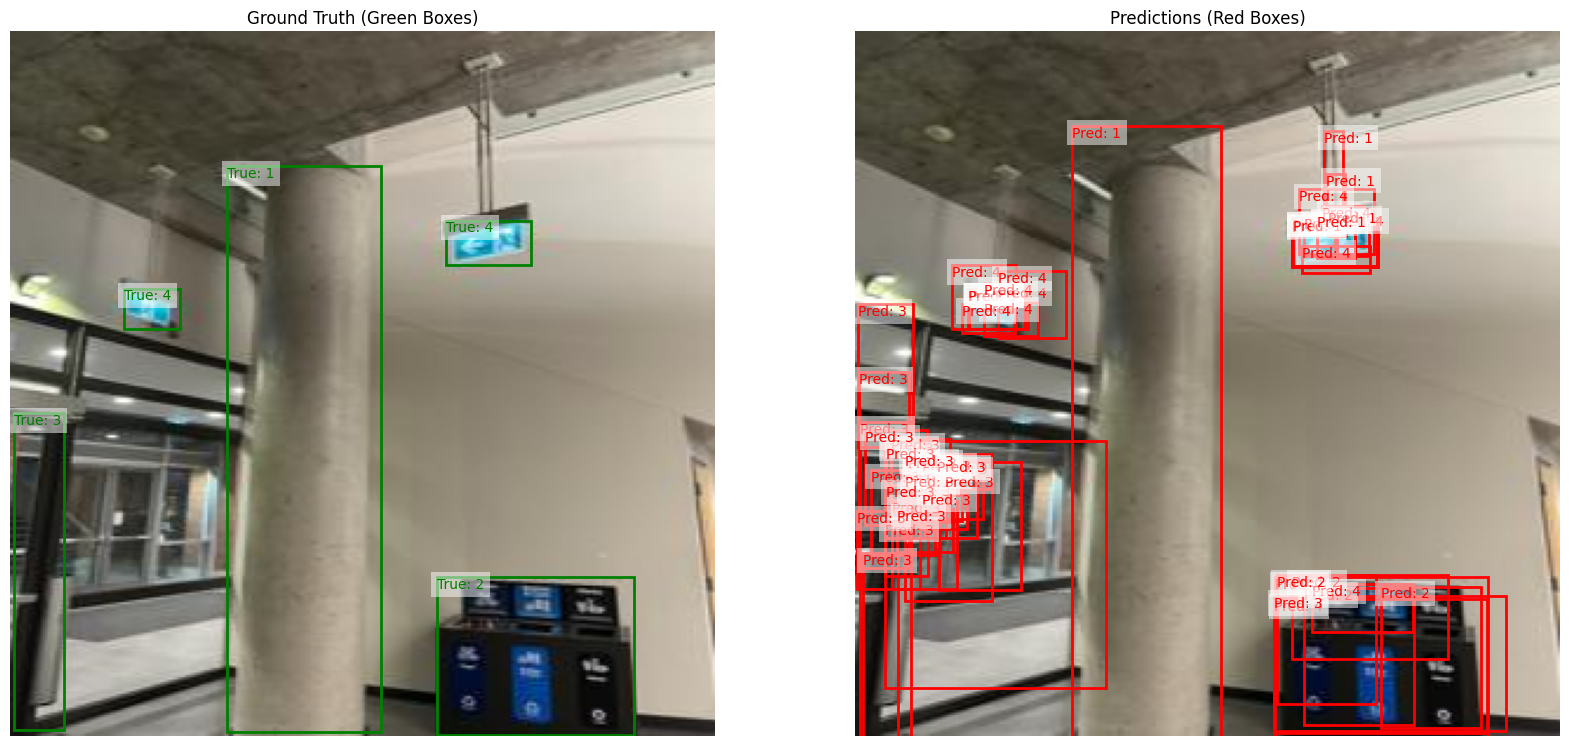

In [198]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def plot_random_image(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: torch.device = device
):
    model.eval()

    with torch.inference_mode():
        images, targets = next(iter(dataloader))
        random_index = random.randint(0, len(images) - 1)

        image = images[random_index].to(device)
        target = targets[random_index]

        predictions = model([image])[0]

        image = F.to_pil_image(image.cpu())

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

        ax1.imshow(image)
        ax1.set_title("Ground Truth (Green Boxes)")
        for box, label in zip(target["boxes"], target["labels"]):
            xmin, ymin, xmax, ymax = box.cpu().numpy()  # Convert to numpy after moving to CPU
            ax1.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                        linewidth=2, edgecolor="green", facecolor="none"))
            ax1.text(xmin, ymin, f"True: {label}", color="green", verticalalignment='top',
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        ax2.imshow(image)
        ax2.set_title("Predictions (Red Boxes)")
        for box, label in zip(predictions["boxes"], predictions["labels"]):
            xmin, ymin, xmax, ymax = box.cpu().numpy()  # Convert to numpy after moving to CPU
            ax2.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                        linewidth=2, edgecolor="red", facecolor="none"))
            ax2.text(xmin, ymin, f"Pred: {label}", color="red", verticalalignment='top',
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        ax1.axis("off")
        ax2.axis("off")

        plt.show()

# Run the plot function
plot_random_image(model, train_dataloader, device)
